# Linear Classification (Softmax) on the MNIST dataset

We will use a multinomial linear classification model to train a model on the MNIST image dataset. 

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import os
import pathlib
import random
import struct

home_dir = "/c/Users/thsiao3/Documents/emory_class/MATH789/hw3"
mnist_dir = "/c/Users/thsiao3/Documents/emory_class/MATH789/mnist_data/"
home_dir = pathlib.Path(home_dir)
mnist_dir = pathlib.Path(mnist_dir)
os.chdir(home_dir)

from softmax import softmaxFun

Some helper functions. Softmax function is confusing but this is the actual link that produces the $\textbf{C}$ labels matrix. 
This is different from softmaxFun, which computes the cross entropy objective function rather than the softmax itself. Also
a plotting MNIST data and weights matrix function. 

In [22]:
def softmax(W, Y):
    S = W @ Y
    D = 1 / (np.sum(np.exp(S), axis=0))
    return np.exp(S) * D

def plot_mnist(pixels):
    plt.gray()
    xaxis = np.tile(np.linspace(0,1,num=28),28)
    yaxis = np.repeat(np.linspace(1,0,num=28),28)
    # Way to remove the tick marks
    plt.xticks([])
    plt.yticks([])
    plt.scatter(xaxis, yaxis, c=pixels, marker="s",s=190)

Since we've been using the MNIST data quite a lot for many things, saved prepped versions of data in a directory. 

In [23]:
train_data = np.load(mnist_dir / "train_data_w_bias.npy").T
train_labels = np.load(mnist_dir / "train_labels_matrix.npy")
train_labels_vec = np.load(mnist_dir / "train_labels_vector.npy")
test_data = np.load(mnist_dir / "test_data_w_bias.npy").T
test_labels = np.load(mnist_dir / "test_labels_vector.npy")

In [24]:
n_f = train_data.shape[0]
n_c = train_labels.shape[0]
n = train_data.shape[1]

In [25]:
Y = train_data
C = train_labels
W = np.zeros((n_c*n_f, 1))

## Method 1: Steepest Descent with Armijo linesearch

In the least squares, we treated the linesearch problem as its own optimization problem within the larger optimization problem of
minimizing the loss function. The philosophy behind Armijo linsearch is that computational resoures should not be spent
minimizing the step size at each step, but rather just get it good enough so that you can spend time picking a better 
search direction in the next step.

In [27]:
def SDLC(E, W, Y, C, alpha0, gamma, maxIter):
    """
    Steepest descent for the multinomial logistic regression with Armijo linesearch. 
    Line search problem isn't as easy as the least squares case. 
    
    Parameters
        E -- function that computes the cross entropy and gradient at W
        W -- starting guess (n_c * n_f) x 1 column vector
        Y -- observations  (n_f x n])
        C -- label matrix  (n_c x n) 
        alpha0 -- max step size to start backtracking from
        gamma -- value to increase step size by if line search is not needed at a step
        maxIter -- num iterations
    
    Returns
        Wsd -- solution (n_c * n_f) x 1
        his -- cross entropy at each step
        Whis -- solution at each iteration
    """
    his = np.zeros(maxIter)
    grad_norm = np.zeros(maxIter)
    for i in np.arange(maxIter):
        alpha = alpha0
        results = E(W, Y, C)
        CE = results[0]
        D = results[1]
        
        # Begin finding step size
        new_W = W - alpha * D
        new_CE = E(new_W, Y, C)[0]
        count = 0
        
        # Keep finding until waiting too long
        while new_CE >= CE and count < 100:
            alpha = 0.5 * alpha
            new_W = W - alpha * D
            new_CE = E(new_W, Y, C)[0]
        
        W = new_W
        his[i] = new_CE
        grad_norm[i] = np.linalg.norm(D)
        
        # Modifying step size for the next step
        if alpha != alpha0:
            alpha0 = alpha
        else:
            alpha0 = gamma * alpha
    
    return W, his, grad_norm
        

In [11]:
# This takes a couple minutes
sol, his, norms = SDLC(softmaxFun, W=W, Y=Y, C=C, alpha0=1, gamma=2, maxIter=50)

Text(0.5, 1.0, 'Objective function')

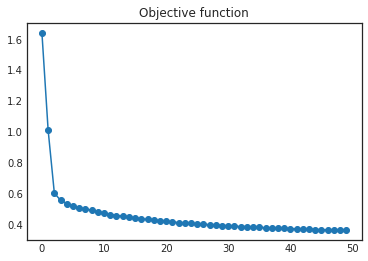

In [12]:
plt.plot(his, marker = "o")
plt.title("Objective function")

Text(0.5, 1.0, 'Norm of gradient at each step')

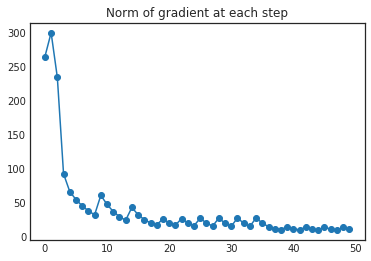

In [13]:
plt.plot(norms, marker = "o")
plt.title("Norm of gradient at each step")

In [16]:
W_est = np.reshape(sol, (n_c, n_f))
C_est_test = softmax(W_est, test_data)
C_est_train = softmax(W_est, train_data)

The accuracy of the multinomial logistic regression, as solved by steepest descent with Armijo linesearch is 

In [19]:
test_accuracy = np.mean(np.argmax(C_est_test, axis=0) == test_labels)
train_accuracy = np.mean(np.argmax(C_est_train, axis=0) == train_labels_vec)
print("Training accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Training accuracy: 0.8967666666666667
Test accuracy: 0.9041


An improvement from 86% for the least squares pseudoinverse solution! Though not as high as the 92% reported by Lars. I probably could have let the steepest descent run longer - may need to tweak parameters a bit more for better convergence. It's interesting that the first steps are the the ones leading to the most drastic loss in cross entropy, while subsequent steps have extremely diminishing returns. Let's visualize the weight matrix. Hopefully it looks more sensical than the random signals on the left side of the images that we saw for linear least squares.

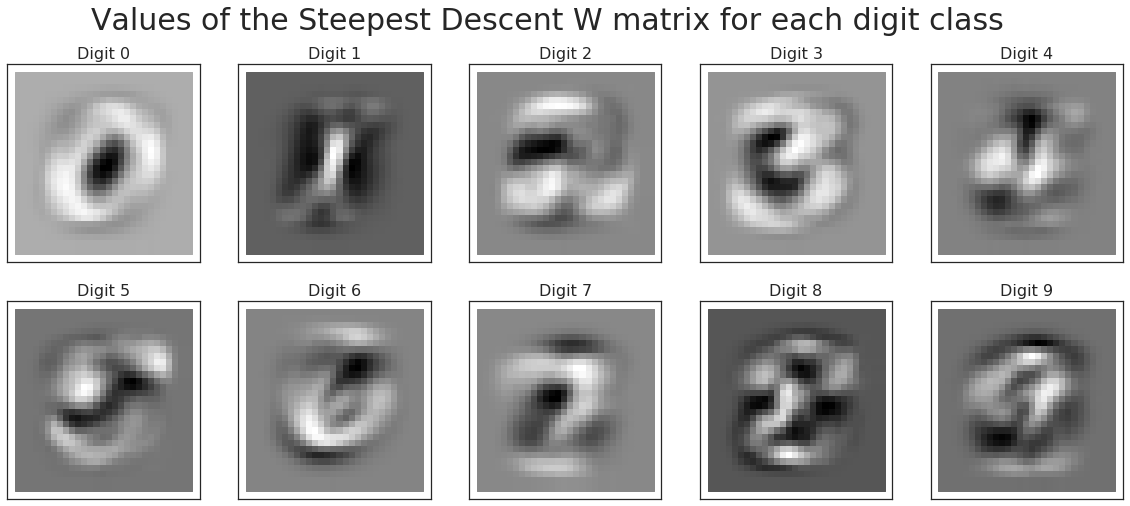

In [25]:
f = plt.figure(figsize=(20, 8))
f.suptitle('Values of the Steepest Descent W matrix for each digit class', fontsize=30)
for k in range(10):
    ax = f.add_subplot(2, 5, k+1)
    plot_mnist(W_est.T[:,k][1:])
    ax.set_title("Digit {}".format(k), fontsize=16)

I can see numbers that actually correspond to the images! This is actually really cool. So changing from straight least squares to
using the softmax function makes such a big difference in terms of the actual patterns that get picked up by the classifier.

## Method 2: Newton-CG with scipy.optimize

In [7]:
import scipy.optimize

In [28]:
def f(W):
    """Objective func"""
    return softmaxFun(W, Y, C)[0]

def grad(W):
    """Gradient"""
    return softmaxFun(W, Y, C)[1][:,0]

In [35]:
newton_sol = scipy.optimize.minimize(method = 'Newton-CG', fun=f, x0=W, jac=grad, 
                                    options={'xtol': 1e-05, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.688908
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 10
         Hessian evaluations: 0


In [36]:
W_newton_est = np.reshape(newton_sol.x, (n_c, n_f))
C_newton_test = softmax(W_newton_est, test_data)
C_newton_train = softmax(W_newton_est, train_data)

In [37]:
test_newton_accuracy = np.mean(np.argmax(C_newton_test, axis=0) == test_labels)
train_newton_accuracy = np.mean(np.argmax(C_newton_train, axis=0) == train_labels_vec)
print("Training accuracy: {}".format(train_newton_accuracy))
print("Test accuracy: {}".format(test_newton_accuracy))

Training accuracy: 0.81765
Test accuracy: 0.8273


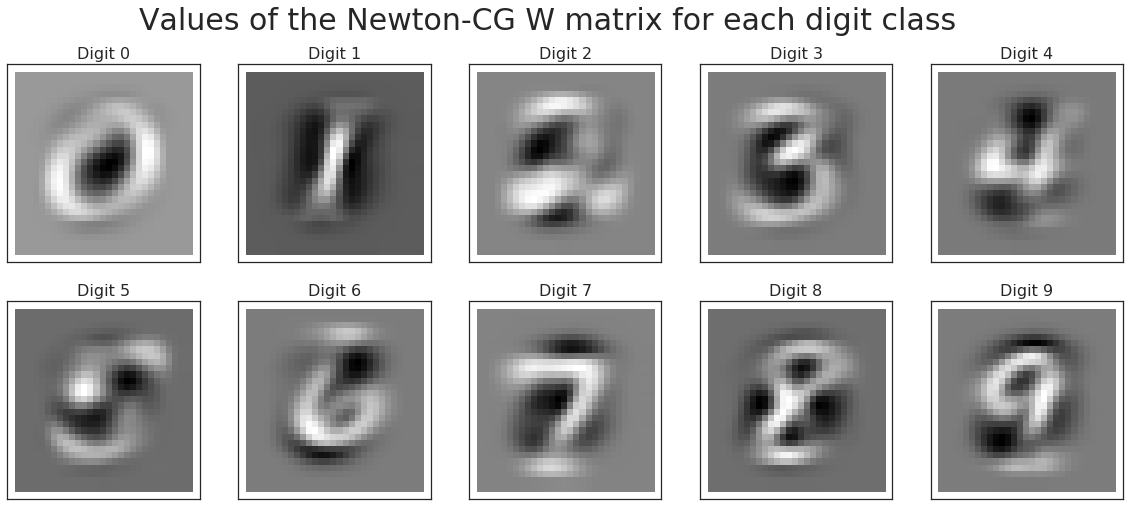

In [38]:
f = plt.figure(figsize=(20, 8))
f.suptitle('Values of the Newton-CG W matrix for each digit class', fontsize=30)
for k in range(10):
    ax = f.add_subplot(2, 5, k+1)
    plot_mnist(W_newton_est.T[:,k][1:])
    ax.set_title("Digit {}".format(k), fontsize=16)

While the accuracy is actually worse than the linear least squares case, the weights matrix looks clearer than the steepest descent softmax solution.